In [1]:
%pylab inline
from clawpack.pyclaw import Solution
import os
import pygmt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_fortq(frame):
    """
    Import fort.q files to get x,y,z data
    """
    fortq = Solution(frame, file_format='ascii')
    patch_dict = {}
    for stateno, state in enumerate(fortq.states):
        patch = state.patch
        level = patch.level
        Xc, Yc = state.grid.c_centers
        h = state.q[0,:,:]
        eta = state.q[3,:,:]
        drytol_default = 0.001
        water = np.copy(eta)
        idx = np.where((h<=drytol_default) & (h>=-drytol_default))
        water[ind] = 0
        
        # Save variables to dictionary
        long=Xc[:,0]
        lat = Yc[0]
        patch_dict[stateno] = {"lat": lat, 'long':long, 'eta':eta, 'amr_level':level}
        return patch_dict, water, h, Xc, Yc, eta

In [15]:
for i in range(4):
    [patch_dict, water,h,X,Y,eta]=water_level(i)
    plt.figure()
    plt.scatter(X,Y,c=water,s=100,cmap=plt.get_cmap('coolwarm'))
    plt.clim(-0.1,0.1)
    plt.colorbar()
    plt.show()

<xarray.Dataset>
Dimensions:       (grid_mapping: 12, x: 8112, y: 8112)
Coordinates:
  * x             (x) float64 -75.25 -75.25 -75.25 -75.25 ... -75.0 -75.0 -75.0
  * y             (y) float64 38.0 38.0 38.0 38.0 ... 38.25 38.25 38.25 38.25
  * grid_mapping  (grid_mapping) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
Data variables:
    z             (y, x) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdconvert
    history:      grdconvert ncei19_n38x25_w075x25_2019v1.tif ncei19_n38x25_w...
    description:  
    GMT_version:  5.4.5 [64-bit] [MP]
    node_offset:  1

In [9]:
file_path = os.path.join('/mnt/c/storm/v6/s00') 

solution = Solution()

drytol_default = .001
x = Solution(4, file_format='ascii')
patches = []
patch_dict = {}
for stateno, state in enumerate(x.states):
    state = x.states[stateno]
    patch = state.patch
    patches.append(patch.patch_index)
    level = patch.level
#     print(stateno, patch.level)
    Xc, Yc = state.grid.c_centers
    xc = Xc[:,0]
    yc = Yc[0,:]
    h = state.q[0,:,:]
    eta = state.q[3,:,:]
#     topo = eta - h
#     # water = np.ma.masked_where(h <= drytol_default, eta)
#     water = eta
#     ind=np.where(h<=drytol_default)
#     nan_index = np.where(eta <=.001)
#     water[ind]=np.nan

#     land = np.ma.masked_where(h > drytol_default, eta)
    long=Xc[:,0]
    lat = Yc[0]
    patch_dict[stateno] = {"lat": lat, 'long':long, 'eta':eta}


In [22]:
water = np.copy(eta)
water
ind=np.where(h<=drytol_default)
nan_index = np.where(eta <=0.001)
water[ind] = np.nan
topo = eta-h
land = np.ma.masked_where(h > drytol_default, eta)
eta

array([[0.82964594, 0.82886538, 0.82788077, 0.83536582, 0.84291023,
        0.85364276, 0.86574222, 0.87716461, 0.88547144, 0.89013894,
        0.89114027, 0.88861215, 0.88322153, 0.87532186, 0.8670585 ,
        0.86055132, 0.85656839, 0.85268331, 0.85590262, 0.85597909],
       [0.81987785, 0.80957344, 0.8039097 , 0.80615326, 0.81048309,
        0.81943174, 0.8322359 , 0.8450351 , 0.85503758, 0.860668  ,
        0.86152972, 0.85816245, 0.85131668, 0.84238921, 0.83415057,
        0.83038061, 0.82940567, 0.82957515, 0.83779516, 0.84600071],
       [0.80821341, 0.79219802, 0.78208534, 0.77943739, 0.77995562,
        0.78720568, 0.80019264, 0.81394208, 0.82466016, 0.83050683,
        0.83107551, 0.82668728, 0.8186225 , 0.8085815 , 0.8005037 ,
        0.79828244, 0.80109745, 0.80479184, 0.81712869, 0.83089599],
       [0.80931711, 0.7914746 , 0.77779007, 0.77243939, 0.77080631,
        0.7774275 , 0.79118819, 0.80643034, 0.81860058, 0.82527788,
        0.82581589, 0.82063168, 0.81127666, 0

In [4]:

this_level = patch.level

xc_centers,yc_centers = patch.grid.c_centers
mask_coarse = np.empty(xc_centers.shape, dtype=bool)
mask_coarse.fill(False)

# iterate over all grids to see which one masks this grid
for stateno_fine,state_fine in enumerate(x.states):
    # iterate over all patches, and find any finer level grids that are
    # sitting on top of this patch/grid/state.
    patch_fine = state_fine.patch

    # Only look at patches one level finer
    if patch_fine.level != this_level+1:
        continue

    xlower_fine = patch_fine.dimensions[0].lower
    xupper_fine = patch_fine.dimensions[0].upper
    ylower_fine = patch_fine.dimensions[1].lower
    yupper_fine = patch_fine.dimensions[1].upper

    m1 = (xc_centers > xlower_fine) & (xc_centers < xupper_fine)
    m2 = (yc_centers > ylower_fine) & (yc_centers < yupper_fine)

    # Mask all fine grid regions
    mask_coarse = (m1 & m2) | mask_coarse

In [5]:
xlow = state.grid.x.lower
ylow = state.grid.y.lower
mx = state.grid.x.num_cells
my = state.grid.y.num_cells
dx = state.grid.x.delta
dy = state.grid.y.delta
print(xlow, mx, dx, ylow, my, dy)
len(patches)

-74.25 22 0.0625 30.875 20 0.0625


6

grdcontour [WARNING]: Your grid x's or longitudes appear to be outside the map region and will be skipped.
grdcontour [WARNING]: No data within specified region
grdcontour [WARNING]: Your grid y's or latitudes appear to be outside the map region and will be skipped.
grdcontour [WARNING]: No data within specified region
grdcontour [WARNING]: No contours drawn, check your -A, -C, -L settings?
grdcontour [WARNING]: Your grid y's or latitudes appear to be outside the map region and will be skipped.
grdcontour [WARNING]: No data within specified region
grdcontour [WARNING]: Your grid y's or latitudes appear to be outside the map region and will be skipped.
grdcontour [WARNING]: No data within specified region
grdcontour [WARNING]: Your grid y's or latitudes appear to be outside the map region and will be skipped.
grdcontour [WARNING]: No data within specified region


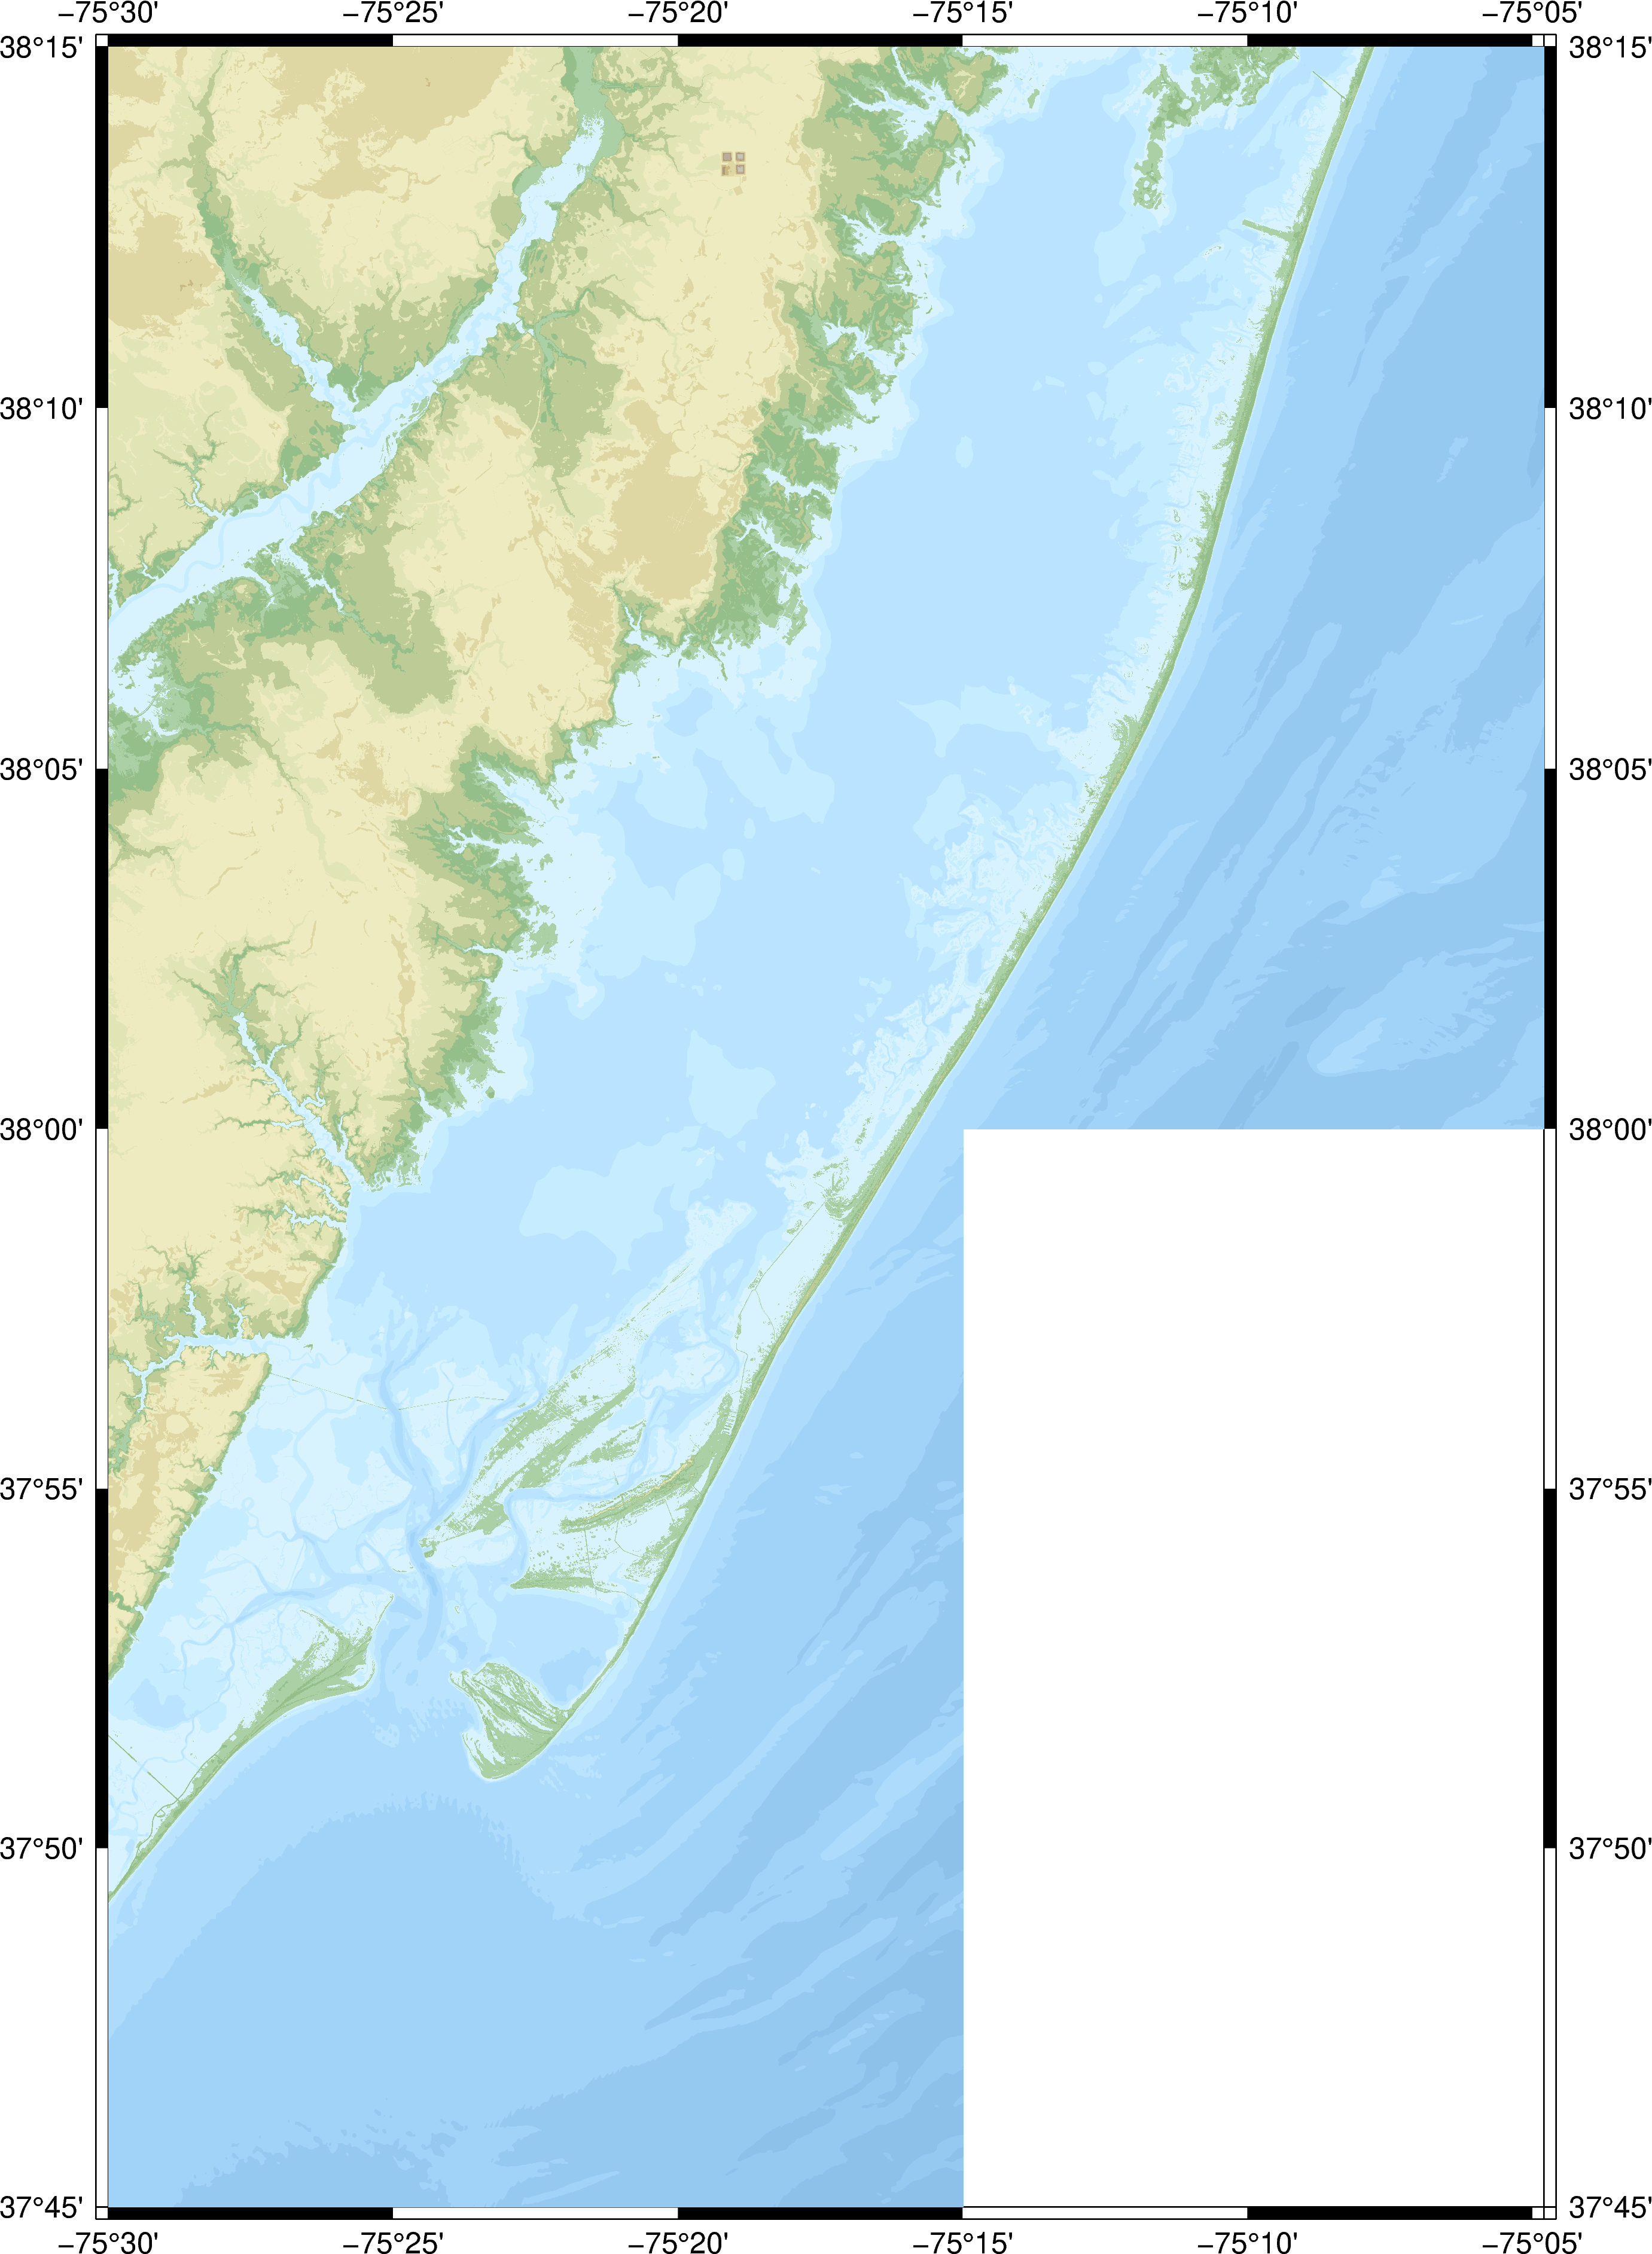

In [11]:
fig = pygmt.Figure()
fig.basemap(region=[-75.5, -75.08, 37.75, 38.25], projection='M8i',frame='a')
path = 'chincoteague'
file = os.path.join(path,'ncei19_n38x00_w075x50_2019v1.grd' )
file2 = os.path.join(path, 'ncei19_n38x25_w075x50_2019v1.grd')
file3 = os.path.join(path, 'ncei19_n38x25_w075x25_2019v1.grd')

pygmt.makecpt(series=[-50, 50], cmap='wiki-france')

fig.grdimage(file)
fig.grdimage(file2)
fig.grdimage(file3)

pygmt.makecpt(series=[-.5, .5], cmap='polar')
# fig.basemap(region=[-75.5, -75.08, 37.80, 38.25], projection='M8i',frame='a')
# fig.grdimage('/mnt/c/Projects/barrier_island/bathy/synthetic_island.tt3')
for patch in patch_dict:
    
    lat = patch_dict[patch]['lat']
    
    long = patch_dict[patch]['long']
    
    eta = patch_dict[patch]['eta']
#     print(patch, lat.min(), lat.max(), long.min(),long.max, eta.min(), eta.max())
    df = pd.DataFrame(data=eta, index=[i for i in long], columns=[i for i in lat])# 'Latitude':lat, 'Longitude':long})
    df.index.name='Longitude'
    df.columns.name="Latitude"
    da=xr.DataArray(data=df.T)
    
#     print(np.isnan(eta).any())
    fig.grdcontour(da)
fig.show()
# da
# fig.grdimage(da)
# fig.show()
# fig = pygmt.Figure()
# fig.basemap(region=[xlow, xlow+(dx*mx), ylow, ylow+(dy*my)], projection='M8i', frame='a')
# fig.coast(shorelines=True)
# fig.show()

this_level = patch.level

                        xc_centers,yc_centers = patch.grid.c_centers
                        mask_coarse = np.empty(xc_centers.shape, dtype=bool)
                        mask_coarse.fill(False)

                        # iterate over all grids to see which one masks this grid
                        for stateno_fine,state_fine in enumerate(framesoln.states):
                            # iterate over all patches, and find any finer level grids that are
                            # sitting on top of this patch/grid/state.
                            patch_fine = state_fine.patch

                            # Only look at patches one level finer
                            if patch_fine.level != this_level+1:
                                continue

                            xlower_fine = patch_fine.dimensions[0].lower
                            xupper_fine = patch_fine.dimensions[0].upper
                            ylower_fine = patch_fine.dimensions[1].lower
                            yupper_fine = patch_fine.dimensions[1].upper

                            m1 = (xc_centers > xlower_fine) & (xc_centers < xupper_fine)
                            m2 = (yc_centers > ylower_fine) & (yc_centers < yupper_fine)

                            # Mask all fine grid regions
                            mask_coarse = (m1 & m2) | mask_coarse


In [12]:
for patch in patch_dict:
    
    lat = patch_dict[patch]['lat']
    
    long = patch_dict[patch]['long']
    
    eta = patch_dict[patch]['eta']
ccrs?


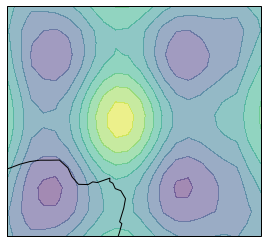

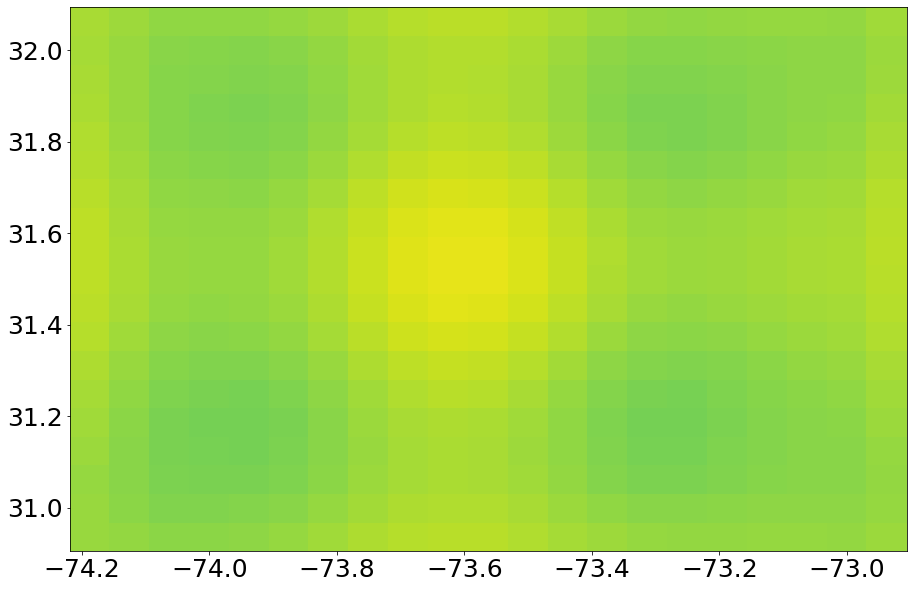

In [7]:
fig = plt.figure(figsize=[10,15])
ax = fig.add_subplot(121, projection=ccrs.PlateCarree([-75.5, -75.08, 37.8, 38.25]))
img_extent = [-75.5, -75.08, 37.8, 38.25]

# ax.set_extent(img_extent)
ax.coastlines()

# ax.contourf(long, lat, eta)


# import numpy as np
# lon = np.linspace(-80, 80, 25)
# lat = np.linspace(30, 70, 25)
# lon2d, lat2d = np.meshgrid(lon, lat)
# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)
ax.contourf(da, alpha=0.5)
plt.show()

fig = plt.figure(2)
plt.pcolor(Xc, Yc, eta, vmin=-0.1, vmax=1.)

In [28]:
eta.max()

0.9612834654690232

In [64]:
# for i in range(mx):
long=Xc[:,0]
lat = Yc[0]
df = pd.DataFrame(data=eta, index=[i for i in long], columns=[i for i in lat])# 'Latitude':lat, 'Longitude':long})
df.index.name='Longitude'
df.columns.name="Latitude"
df.T

Longitude,-98.998437,-98.995312,-98.992188,-98.989063,-98.985938,-98.982812,-98.979687,-98.976562,-98.973438,-98.970313,...,-98.917187,-98.914062,-98.910938,-98.907813,-98.904688,-98.901562,-98.898438,-98.895313,-98.892188,-98.889063
Latitude,,,,,,,,,,,,,,,,,,,,,
29.226562,0.178287,0.178284,0.178281,0.178277,0.178274,0.178271,0.178268,0.178265,0.178262,0.178260,...,0.178214,0.178211,0.178209,0.178207,0.178204,0.178202,0.178200,0.178197,0.178195,0.178193
29.229688,0.178316,0.178312,0.178309,0.178306,0.178303,0.178300,0.178297,0.178294,0.178291,0.178288,...,0.178242,0.178240,0.178237,0.178235,0.178233,0.178230,0.178228,0.178226,0.178223,0.178221
29.232813,0.178345,0.178342,0.178338,0.178335,0.178332,0.178329,0.178326,0.178323,0.178320,0.178317,...,0.178271,0.178269,0.178266,0.178264,0.178261,0.178259,0.178257,0.178255,0.178252,0.178250
29.235938,0.178374,0.178371,0.178368,0.178365,0.178361,0.178358,0.178355,0.178352,0.178349,0.178346,...,0.178300,0.178298,0.178295,0.178293,0.178290,0.178288,0.178286,0.178284,0.178281,0.178279
29.239063,0.178403,0.178400,0.178397,0.178394,0.178390,0.178387,0.178384,0.178381,0.178378,0.178375,...,0.178329,0.178326,0.178324,0.178322,0.178319,0.178317,0.178315,0.178312,0.178310,0.178308
29.242188,0.178432,0.178429,0.178426,0.178423,0.178420,0.178416,0.178413,0.178410,0.178407,0.178404,...,0.178358,0.178355,0.178353,0.178350,0.178348,0.178346,0.178343,0.178341,0.178339,0.178337
29.245313,0.178461,0.178458,0.178455,0.178452,0.178449,0.178445,0.178442,0.178439,0.178436,0.178433,...,0.178387,0.178384,0.178382,0.178379,0.178377,0.178375,0.178372,0.178370,0.178368,0.178365
29.248438,0.178491,0.178487,0.178484,0.178481,0.178478,0.178474,0.178471,0.178468,0.178465,0.178462,...,0.178415,0.178413,0.178410,0.178408,0.178406,0.178403,0.178401,0.178399,0.178396,0.178394
29.251563,0.178520,0.178516,0.178513,0.178510,0.178507,0.178504,0.178500,0.178497,0.178494,0.178491,...,0.178444,0.178442,0.178439,0.178437,0.178434,0.178432,0.178430,0.178427,0.178425,0.178423


In [ ]:

# R = '-R-99/-70/8/32'
# map_cpt = '-C/Users/jeffriesc/Research_Stuff/PreClaw/MapTools/AGUPosterGMT/wiki-france.cpt'
# water_cpt = '-Cland-water11.cpt'
# J = '-JM3.0i'

# subprocess.run([gmt, 'psbasemap', R, J, '-K'
#                  '-BneSW', '-Bxa5f1', '-Bya5f1', '>', 'test.ps'])
# subprocess.run([gmt, 'grdimage', '/Users/jeffriesc/Data/World/Bathy/entire_world_srtm15_new.grd',
#                 R, '-JM3.0i',  map_cpt,'-K','-O', '>>', 'test.ps'])
# subprocess.run([gmt, 'pscoast', R, J, '-Dh', '-O', '-Cblue', '-Ir/.25,cyan', '-Na', '-t75', '-W', '-K', '>>', 'test.ps'])

# for i in range(1):
#
#     name = 'test_{}'.format(i)
#     name2 = 'topo_{}'.format(i)
#     file = name + '.txt'
#     file2 = name + '.txt'
#     # f2 = 'test_grd_info{}'.format(i)
#     # f2_name = f2 + '.txt'
#     I = '-I20m'
#     subprocess.run([gmt, 'xyz2grd', '-G{}.grd'.format(name), '{}'.format(file), I, '-D0invalid',
#                     R])
#     # subprocess.run([gmt, 'xyz2grd', '-G{}.grd'.format(name2), '{}'.format(file2), I, '-D0'
#     #                 R])
#     # subprocess.run([gmt, 'makecpt', '-Cpolar', '-T-1/1' '>', 'tsunami.cpt'])
#     subprocess.run([gmt, 'grdimage', '{}.grd'.format(name),J ,R,'-O', '-Q',
#                     water_cpt,'-K', '>>', 'test.ps' ])
#     # subprocess.run([gmt, 'grdimage', '{}.grd'.format(name2), '-JM3.0i', R, '-O', '-Q'
#     #                                 '-Cwiki-france', '-K', '>>', 'test.ps'])
# for i in range(2, 5):
#
#     name = 'test_{}'.format(i)
#     file = name + '.txt'
#     # f2 = 'test_grd_info{}'.format(i)
#     # f2_name = f2 + '.txt'
#     I = '-I5m'
#     subprocess.run([gmt, 'xyz2grd', '-G{}.grd'.format(name), '{}'.format(file), I,
#                     R])
#     # subprocess.run([gmt, 'makecpt', '-Cpolar', '-T-1/1' '>', 'tsunami.cpt'])
#     subprocess.run([gmt, 'grdimage', '{}.grd'.format(name), '-Q',J ,R,'-O',
#                     water_cpt,'-K', '>>', 'test.ps' ])
#
# for i in range(5,69):
#
#     name = 'test_{}'.format(i)
#     file = name + '.txt'
#     # f2 = 'test_grd_info{}'.format(i)
#     # f2_name = f2 + '.txt'
#     I = '-I1m'
#     subprocess.run([gmt, 'xyz2grd', '-G{}.grd'.format(name), '{}'.format(file), I,
#                     R])
#     # subprocess.run([gmt, 'makecpt', '-Cpolar', '-T-1/1' '>', 'tsunami.cpt'])
#     subprocess.run([gmt, 'grdimage', '{}.grd'.format(name), '-Q',J ,R,'-O',
#                     water_cpt,'-K', '>>', 'test.ps' ])
#
# for i in range(69,1093):
#
#     name = 'test_{}'.format(i)
#     file = name + '.txt'
#     # f2 = 'test_grd_info{}'.format(i)
#     # f2_name = f2 + '.txt'
#     I = '-I10s'
#     subprocess.run([gmt, 'xyz2grd', '-G{}.grd'.format(name), '{}'.format(file), I,
#                     R])
#     # subprocess.run([gmt, 'makecpt', '-Cpolar', '-T-1/1' '>', 'tsunami.cpt'])
#     subprocess.run([gmt, 'grdimage', '{}.grd'.format(name), '-Q',J ,R,'-O',
#                     water_cpt,'-K', '>>', 'test.ps' ])

# subprocess.run([gmt, 'psscale', '-D.05/-1.85+w7.5c/.5c+h', '-Bxaf+lSlip (m)',
#                 '-C/Users/jeffriesc/Data/NA_CAS/CPT/central.cpt', '-O','>>', 'test.ps'])


